# Part 2, Beat IBB Index

The second part of application in the paper is to select a subset of stocks from IBB Index to beat the Index.

In [21]:
# Run some setup code for this notebook.
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict

** Load data **

- `index_col = 0`: since first column is date (useless for training), let's keep it as index
- `dropna(axis=1, how='any')`: drop any stock with any n/a (missing) data
- `astype('float32')`: datatype

Finally we only have **83** stocks to use.

In [22]:
# Load data

# stock componenet data
stock = defaultdict(defaultdict)

stock_lp = pd.read_csv('data/last_price.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['lp'] = stock_lp.iloc[0:104, :]
stock['validate']['lp'] = stock_lp.iloc[104:, :]

stock_net = pd.read_csv('data/net_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['net'] = stock_net.iloc[0:104, :]
stock['validate']['net'] = stock_net.iloc[104:, :]

stock_percentage = pd.read_csv('data/percentage_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['percentage'] = stock_percentage.iloc[0:104, :]
stock['validate']['percentage'] = stock_percentage.iloc[104:, :]


# ibb data
ibb = defaultdict(defaultdict)
ibb_full = pd.read_csv('data/ibb.csv', index_col=0).astype('float32')

ibb_lp = ibb_full.iloc[:,0] # Series
ibb['calibrate']['lp'] = ibb_lp[0:104]
ibb['validate']['lp'] = ibb_lp[104:]

ibb_net = ibb_full.iloc[:,1] # Series
ibb['calibrate']['net'] = ibb_net[0:104]
ibb['validate']['net'] = ibb_net[104:]

ibb_percentage = ibb_full.iloc[:,2] # Series
ibb['calibrate']['percentage'] = ibb_percentage[0:104]
ibb['validate']['percentage'] = ibb_percentage[104:]

# Phase 1. Auto-encoding

1. Train an auto-encoder model compressing market information.
2. Rank stocks by 2-norm difference then select subset of them as our portfolio.
3. Page 7 of the paper: ReLU + linear as activation functions
4. Weights $W = (W_1, W_2)$, L2 regularization


Some problems I did not figure out (or the paper did not mention about the details):
1. which weekly return/what data to be used? (what can represent best market information?)
2. How to do the data preprocessing?
3. How to perform 4-fold validation in Deep Learning?

In [23]:
encoding_dim = 5 # 5 neurons
num_stock = len(stock_lp.columns) # Use 83 stocks as features

# connect all layers
input_img = Input(shape=(num_stock, ))
encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
decoded = Dense(num_stock, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded) # see 'Stacked Auto-Encoders' in paper

# construct and compile AE model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

# train autoencoder
data = stock['calibrate']['net']
autoencoder.fit(data, data, shuffle=False, epochs=500, batch_size = 10)
autoencoder.save('model/beat_autoencoder.h5')

# test/reconstruct market information matrix
reconstruct = autoencoder.predict(data)

Epoch 1/500
104/104 [==============================] - 1s 6ms/step - loss: 5.7840
Epoch 2/500
104/104 [==============================] - 0s 116us/step - loss: 5.6514
Epoch 3/500
104/104 [==============================] - 0s 105us/step - loss: 5.5713
Epoch 4/500
104/104 [==============================] - 0s 106us/step - loss: 5.5166
Epoch 5/500
104/104 [==============================] - 0s 101us/step - loss: 5.4732
Epoch 6/500
104/104 [==============================] - 0s 106us/step - loss: 5.4363
Epoch 7/500
104/104 [==============================] - 0s 104us/step - loss: 5.4023
Epoch 8/500
104/104 [==============================] - 0s 116us/step - loss: 5.3709
Epoch 9/500
104/104 [==============================] - 0s 105us/step - loss: 5.3411
Epoch 10/500
104/104 [==============================] - 0s 106us/step - loss: 5.3110
Epoch 11/500
104/104 [==============================] - 0s 104us/step - loss: 5.2778
Epoch 12/500
104/104 [==============================] - 0s 108us/step - loss

104/104 [==============================] - 0s 102us/step - loss: 2.8282
Epoch 98/500
104/104 [==============================] - 0s 103us/step - loss: 2.8219
Epoch 99/500
104/104 [==============================] - 0s 102us/step - loss: 2.8157
Epoch 100/500
104/104 [==============================] - 0s 100us/step - loss: 2.8097
Epoch 101/500
104/104 [==============================] - 0s 104us/step - loss: 2.8037
Epoch 102/500
104/104 [==============================] - 0s 105us/step - loss: 2.7978
Epoch 103/500
104/104 [==============================] - 0s 102us/step - loss: 2.7921
Epoch 104/500
104/104 [==============================] - 0s 106us/step - loss: 2.7864
Epoch 105/500
104/104 [==============================] - 0s 104us/step - loss: 2.7808
Epoch 106/500
104/104 [==============================] - 0s 103us/step - loss: 2.7753
Epoch 107/500
104/104 [==============================] - 0s 108us/step - loss: 2.7699
Epoch 108/500
104/104 [==============================] - 0s 107us/step

104/104 [==============================] - 0s 107us/step - loss: 2.5410
Epoch 193/500
104/104 [==============================] - 0s 104us/step - loss: 2.5398
Epoch 194/500
104/104 [==============================] - 0s 107us/step - loss: 2.5386
Epoch 195/500
104/104 [==============================] - 0s 105us/step - loss: 2.5374
Epoch 196/500
104/104 [==============================] - 0s 109us/step - loss: 2.5363
Epoch 197/500
104/104 [==============================] - 0s 104us/step - loss: 2.5352
Epoch 198/500
104/104 [==============================] - 0s 104us/step - loss: 2.5341
Epoch 199/500
104/104 [==============================] - 0s 104us/step - loss: 2.5331
Epoch 200/500
104/104 [==============================] - 0s 106us/step - loss: 2.5321
Epoch 201/500
104/104 [==============================] - 0s 112us/step - loss: 2.5312
Epoch 202/500
104/104 [==============================] - 0s 108us/step - loss: 2.5290
Epoch 203/500
104/104 [==============================] - 0s 105us/st

104/104 [==============================] - 0s 104us/step - loss: 2.4155
Epoch 288/500
104/104 [==============================] - 0s 111us/step - loss: 2.4141
Epoch 289/500
104/104 [==============================] - 0s 106us/step - loss: 2.4127
Epoch 290/500
104/104 [==============================] - 0s 103us/step - loss: 2.4112
Epoch 291/500
104/104 [==============================] - 0s 107us/step - loss: 2.4099
Epoch 292/500
104/104 [==============================] - 0s 104us/step - loss: 2.4085
Epoch 293/500
104/104 [==============================] - 0s 102us/step - loss: 2.4071
Epoch 294/500
104/104 [==============================] - 0s 104us/step - loss: 2.4057
Epoch 295/500
104/104 [==============================] - 0s 105us/step - loss: 2.4044
Epoch 296/500
104/104 [==============================] - 0s 104us/step - loss: 2.4030
Epoch 297/500
104/104 [==============================] - 0s 104us/step - loss: 2.4017
Epoch 298/500
104/104 [==============================] - 0s 107us/st

104/104 [==============================] - 0s 104us/step - loss: 2.3034
Epoch 383/500
104/104 [==============================] - 0s 103us/step - loss: 2.3027
Epoch 384/500
104/104 [==============================] - 0s 105us/step - loss: 2.3021
Epoch 385/500
104/104 [==============================] - 0s 102us/step - loss: 2.3014
Epoch 386/500
104/104 [==============================] - 0s 103us/step - loss: 2.3007
Epoch 387/500
104/104 [==============================] - 0s 103us/step - loss: 2.3000
Epoch 388/500
104/104 [==============================] - 0s 104us/step - loss: 2.2993
Epoch 389/500
104/104 [==============================] - 0s 101us/step - loss: 2.2987
Epoch 390/500
104/104 [==============================] - 0s 104us/step - loss: 2.2980
Epoch 391/500
104/104 [==============================] - 0s 104us/step - loss: 2.2974
Epoch 392/500
104/104 [==============================] - 0s 100us/step - loss: 2.2967
Epoch 393/500
104/104 [==============================] - 0s 105us/st

104/104 [==============================] - 0s 104us/step - loss: 2.2575
Epoch 478/500
104/104 [==============================] - 0s 106us/step - loss: 2.2571
Epoch 479/500
104/104 [==============================] - 0s 105us/step - loss: 2.2568
Epoch 480/500
104/104 [==============================] - 0s 102us/step - loss: 2.2565
Epoch 481/500
104/104 [==============================] - 0s 106us/step - loss: 2.2562
Epoch 482/500
104/104 [==============================] - 0s 104us/step - loss: 2.2559
Epoch 483/500
104/104 [==============================] - 0s 105us/step - loss: 2.2555
Epoch 484/500
104/104 [==============================] - 0s 111us/step - loss: 2.2552
Epoch 485/500
104/104 [==============================] - 0s 106us/step - loss: 2.2550
Epoch 486/500
104/104 [==============================] - 0s 107us/step - loss: 2.2546
Epoch 487/500
104/104 [==============================] - 0s 105us/step - loss: 2.2543
Epoch 488/500
104/104 [==============================] - 0s 103us/st

** Communal Information **

- Compute $||X - \hat{X}||$ as 2 norm difference
- The least 2 norm difference a stock has, the more important role it plays in the compressed market auto-encoder
- The paper says that, AMGN should be the best, and BCRX should be the worst. (But I didn't achieve this result.)

In [24]:
communal_information = []

for i in range(0,83):
    diff = np.linalg.norm((data.iloc[:,i] - reconstruct[:,i])) # 2 norm difference
    communal_information.append(float(diff))
 
print("stock #, 2-norm, stock name")
ranking = np.array(communal_information).argsort()
for stock_index in ranking:
    print(stock_index, communal_information[stock_index], stock['calibrate']['net'].iloc[:,stock_index].name) # print stock name from lowest different to highest

stock #, 2-norm, stock name
68 1.3074113130569458 TLGT    US Equity
65 1.3429088592529297 INO     US Equity
38 1.5994354486465454 LXRX    US Equity
76 1.8013192415237427 NVAX    US Equity
66 2.1215388774871826 CERS    US Equity
79 2.2013001441955566 ZGNX    US Equity
81 2.4248218536376953 MNOV    US Equity
77 2.425579309463501 PDLI    US Equity
71 2.4544551372528076 CRIS    US Equity
52 2.812404155731201 IMMU    US Equity
17 2.849188804626465 EXEL    US Equity
49 3.0675246715545654 DEPO    US Equity
75 3.116823434829712 GERN    US Equity
37 3.3783323764801025 ARRY    US Equity
73 3.614259958267212 AVDL    US Equity
67 3.6680502891540527 PACB    US Equity
48 3.8258655071258545 SGYP    US Equity
19 4.064361572265625 OPK     US Equity
42 4.183863639831543 RGEN    US Equity
55 4.2209553718566895 BCRX    US Equity
72 4.2341084480285645 PRTK    US Equity
31 4.2484941482543945 HZNP    US Equity
82 4.354197025299072 ARWR    US Equity
80 4.586928844451904 CGEN    US Equity
69 4.8720598220825195

Let's have a look on how well this auto-encoder works on a certain stock.

/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


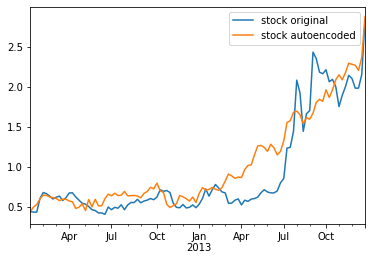

In [25]:
which_stock = 65

# now decoded last price plot
stock_autoencoder = copy.deepcopy(reconstruct[:, which_stock])
stock_autoencoder[0] = 0
stock_autoencoder = stock_autoencoder.cumsum()
stock_autoencoder += (stock['calibrate']['lp'].iloc[0, which_stock])

## plot for comparison
pd.Series(stock['calibrate']['lp'].iloc[:, which_stock].as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='stock original', legend=True)
pd.Series(stock_autoencoder, index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='stock autoencoded', legend=True)

# Phase 2: Calibrating

For the application of beating the IBB index, we will amend the target data during the calibration phase by replacing all returns smaller than -5% by exactly 5%, which aims to create an index tracker with anti-correlation in periods of large drawdowns.

The comparison is shown as bellow.

/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


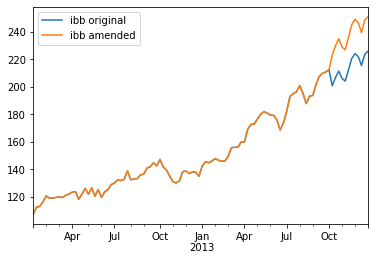

In [26]:
# from -5% to 5%
y_amended = ibb['calibrate']['percentage']
y_amended[y_amended < -5] = 5

# re-calculate the last price
y_amended[0] = 0
relative_percentage = (y_amended /100) + 1
lp_amended = ibb['calibrate']['lp'][0] * (relative_percentage.cumprod()) 

# plot comparison
pd.Series(ibb['calibrate']['lp'].as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='ibb original', legend=True) 
pd.Series(lp_amended.as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='ibb amended', legend=True)   

In [27]:
ibb_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)

for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    
    
    # connect all layers
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.005))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.005))(encoded)
    
    
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = stock['calibrate']['percentage'].iloc[:, stock_index]
    y = y_amended # amended percentage
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    deep_learner.fit(x, y, shuffle=False, epochs=500, batch_size = 10)    # fit the model
    deep_learner.save('model/beat_s' + str(s) + '.h5') # for validation phase use
    
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage/100) + 1
    
    ibb_predict['calibrate'][s] = ibb['calibrate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['calibrate'][s] = np.linalg.norm((ibb_predict['calibrate'][s] - lp_amended)) # compare with amended last price

Epoch 1/500
104/104 [==============================] - 1s 6ms/step - loss: 4.2579
Epoch 2/500
104/104 [==============================] - 0s 165us/step - loss: 2.1253
Epoch 3/500
104/104 [==============================] - 0s 135us/step - loss: 1.7194
Epoch 4/500
104/104 [==============================] - 0s 105us/step - loss: 1.5315
Epoch 5/500
104/104 [==============================] - 0s 101us/step - loss: 1.3982
Epoch 6/500
104/104 [==============================] - 0s 102us/step - loss: 1.2948
Epoch 7/500
104/104 [==============================] - 0s 101us/step - loss: 1.1978
Epoch 8/500
104/104 [==============================] - 0s 98us/step - loss: 1.1193
Epoch 9/500
104/104 [==============================] - 0s 103us/step - loss: 1.0476
Epoch 10/500
104/104 [==============================] - 0s 100us/step - loss: 0.9884
Epoch 11/500
104/104 [==============================] - 0s 102us/step - loss: 0.9386
Epoch 12/500
104/104 [==============================] - 0s 101us/step - loss:

104/104 [==============================] - 0s 98us/step - loss: 0.3109
Epoch 98/500
104/104 [==============================] - 0s 102us/step - loss: 0.3113
Epoch 99/500
104/104 [==============================] - 0s 101us/step - loss: 0.3075
Epoch 100/500
104/104 [==============================] - 0s 100us/step - loss: 0.3084
Epoch 101/500
104/104 [==============================] - 0s 103us/step - loss: 0.3063
Epoch 102/500
104/104 [==============================] - 0s 103us/step - loss: 0.3053
Epoch 103/500
104/104 [==============================] - 0s 101us/step - loss: 0.3028
Epoch 104/500
104/104 [==============================] - 0s 101us/step - loss: 0.3023
Epoch 105/500
104/104 [==============================] - 0s 101us/step - loss: 0.3003
Epoch 106/500
104/104 [==============================] - 0s 99us/step - loss: 0.2989
Epoch 107/500
104/104 [==============================] - 0s 103us/step - loss: 0.2988
Epoch 108/500
104/104 [==============================] - 0s 104us/step -

104/104 [==============================] - 0s 99us/step - loss: 0.2389
Epoch 193/500
104/104 [==============================] - 0s 108us/step - loss: 0.2361
Epoch 194/500
104/104 [==============================] - 0s 98us/step - loss: 0.2372
Epoch 195/500
104/104 [==============================] - 0s 101us/step - loss: 0.2350
Epoch 196/500
104/104 [==============================] - 0s 101us/step - loss: 0.2349
Epoch 197/500
104/104 [==============================] - 0s 100us/step - loss: 0.2341
Epoch 198/500
104/104 [==============================] - 0s 101us/step - loss: 0.2328
Epoch 199/500
104/104 [==============================] - 0s 103us/step - loss: 0.2320
Epoch 200/500
104/104 [==============================] - 0s 106us/step - loss: 0.2317
Epoch 201/500
104/104 [==============================] - 0s 103us/step - loss: 0.2297
Epoch 202/500
104/104 [==============================] - 0s 100us/step - loss: 0.2303
Epoch 203/500
104/104 [==============================] - 0s 102us/step

104/104 [==============================] - 0s 99us/step - loss: 0.1844
Epoch 288/500
104/104 [==============================] - 0s 98us/step - loss: 0.1833
Epoch 289/500
104/104 [==============================] - 0s 99us/step - loss: 0.1848
Epoch 290/500
104/104 [==============================] - 0s 101us/step - loss: 0.1825
Epoch 291/500
104/104 [==============================] - 0s 98us/step - loss: 0.1838
Epoch 292/500
104/104 [==============================] - 0s 99us/step - loss: 0.1822
Epoch 293/500
104/104 [==============================] - 0s 100us/step - loss: 0.1831
Epoch 294/500
104/104 [==============================] - 0s 104us/step - loss: 0.1812
Epoch 295/500
104/104 [==============================] - 0s 106us/step - loss: 0.1823
Epoch 296/500
104/104 [==============================] - 0s 101us/step - loss: 0.1817
Epoch 297/500
104/104 [==============================] - 0s 101us/step - loss: 0.1814
Epoch 298/500
104/104 [==============================] - 0s 102us/step - 

104/104 [==============================] - 0s 106us/step - loss: 0.1625
Epoch 383/500
104/104 [==============================] - 0s 100us/step - loss: 0.1614
Epoch 384/500
104/104 [==============================] - 0s 101us/step - loss: 0.1615
Epoch 385/500
104/104 [==============================] - 0s 103us/step - loss: 0.1614
Epoch 386/500
104/104 [==============================] - 0s 100us/step - loss: 0.1608
Epoch 387/500
104/104 [==============================] - 0s 100us/step - loss: 0.1610
Epoch 388/500
104/104 [==============================] - 0s 102us/step - loss: 0.1604
Epoch 389/500
104/104 [==============================] - 0s 104us/step - loss: 0.1613
Epoch 390/500
104/104 [==============================] - 0s 103us/step - loss: 0.1601
Epoch 391/500
104/104 [==============================] - 0s 101us/step - loss: 0.1611
Epoch 392/500
104/104 [==============================] - 0s 102us/step - loss: 0.1595
Epoch 393/500
104/104 [==============================] - 0s 101us/st

104/104 [==============================] - 0s 98us/step - loss: 0.1529
Epoch 478/500
104/104 [==============================] - 0s 99us/step - loss: 0.1523
Epoch 479/500
104/104 [==============================] - 0s 102us/step - loss: 0.1520
Epoch 480/500
104/104 [==============================] - 0s 100us/step - loss: 0.1531
Epoch 481/500
104/104 [==============================] - 0s 96us/step - loss: 0.1519
Epoch 482/500
104/104 [==============================] - 0s 100us/step - loss: 0.1518
Epoch 483/500
104/104 [==============================] - 0s 97us/step - loss: 0.1529
Epoch 484/500
104/104 [==============================] - 0s 99us/step - loss: 0.1512
Epoch 485/500
104/104 [==============================] - 0s 101us/step - loss: 0.1530
Epoch 486/500
104/104 [==============================] - 0s 97us/step - loss: 0.1513
Epoch 487/500
104/104 [==============================] - 0s 97us/step - loss: 0.1523
Epoch 488/500
104/104 [==============================] - 0s 97us/step - los

104/104 [==============================] - 0s 101us/step - loss: 0.1676
Epoch 74/500
104/104 [==============================] - 0s 100us/step - loss: 0.1638
Epoch 75/500
104/104 [==============================] - 0s 102us/step - loss: 0.1608
Epoch 76/500
104/104 [==============================] - 0s 101us/step - loss: 0.1579
Epoch 77/500
104/104 [==============================] - 0s 102us/step - loss: 0.1558
Epoch 78/500
104/104 [==============================] - 0s 104us/step - loss: 0.1527
Epoch 79/500
104/104 [==============================] - 0s 100us/step - loss: 0.1499
Epoch 80/500
104/104 [==============================] - 0s 99us/step - loss: 0.1483
Epoch 81/500
104/104 [==============================] - 0s 104us/step - loss: 0.1455
Epoch 82/500
104/104 [==============================] - 0s 103us/step - loss: 0.1435
Epoch 83/500
104/104 [==============================] - 0s 98us/step - loss: 0.1414
Epoch 84/500
104/104 [==============================] - 0s 104us/step - loss: 0.

104/104 [==============================] - 0s 103us/step - loss: 0.0844
Epoch 169/500
104/104 [==============================] - 0s 102us/step - loss: 0.0843
Epoch 170/500
104/104 [==============================] - 0s 100us/step - loss: 0.0841
Epoch 171/500
104/104 [==============================] - 0s 103us/step - loss: 0.0838
Epoch 172/500
104/104 [==============================] - 0s 104us/step - loss: 0.0837
Epoch 173/500
104/104 [==============================] - 0s 105us/step - loss: 0.0835
Epoch 174/500
104/104 [==============================] - 0s 117us/step - loss: 0.0833
Epoch 175/500
104/104 [==============================] - 0s 104us/step - loss: 0.0831
Epoch 176/500
104/104 [==============================] - 0s 113us/step - loss: 0.0829
Epoch 177/500
104/104 [==============================] - 0s 108us/step - loss: 0.0828
Epoch 178/500
104/104 [==============================] - 0s 100us/step - loss: 0.0826
Epoch 179/500
104/104 [==============================] - 0s 102us/st

104/104 [==============================] - 0s 101us/step - loss: 0.0740
Epoch 264/500
104/104 [==============================] - 0s 102us/step - loss: 0.0740
Epoch 265/500
104/104 [==============================] - 0s 102us/step - loss: 0.0739
Epoch 266/500
104/104 [==============================] - 0s 104us/step - loss: 0.0738
Epoch 267/500
104/104 [==============================] - 0s 100us/step - loss: 0.0738
Epoch 268/500
104/104 [==============================] - 0s 101us/step - loss: 0.0737
Epoch 269/500
104/104 [==============================] - 0s 107us/step - loss: 0.0737
Epoch 270/500
104/104 [==============================] - 0s 100us/step - loss: 0.0736
Epoch 271/500
104/104 [==============================] - 0s 101us/step - loss: 0.0735
Epoch 272/500
104/104 [==============================] - 0s 104us/step - loss: 0.0735
Epoch 273/500
104/104 [==============================] - 0s 100us/step - loss: 0.0734
Epoch 274/500
104/104 [==============================] - 0s 105us/st

104/104 [==============================] - 0s 106us/step - loss: 0.0695
Epoch 359/500
104/104 [==============================] - 0s 101us/step - loss: 0.0695
Epoch 360/500
104/104 [==============================] - 0s 101us/step - loss: 0.0695
Epoch 361/500
104/104 [==============================] - 0s 103us/step - loss: 0.0694
Epoch 362/500
104/104 [==============================] - 0s 104us/step - loss: 0.0694
Epoch 363/500
104/104 [==============================] - 0s 104us/step - loss: 0.0694
Epoch 364/500
104/104 [==============================] - 0s 99us/step - loss: 0.0693
Epoch 365/500
104/104 [==============================] - 0s 100us/step - loss: 0.0693
Epoch 366/500
104/104 [==============================] - 0s 97us/step - loss: 0.0693
Epoch 367/500
104/104 [==============================] - 0s 97us/step - loss: 0.0692
Epoch 368/500
104/104 [==============================] - 0s 98us/step - loss: 0.0692
Epoch 369/500
104/104 [==============================] - 0s 100us/step -

104/104 [==============================] - 0s 107us/step - loss: 0.0667
Epoch 454/500
104/104 [==============================] - 0s 103us/step - loss: 0.0667
Epoch 455/500
104/104 [==============================] - 0s 113us/step - loss: 0.0667
Epoch 456/500
104/104 [==============================] - 0s 108us/step - loss: 0.0666
Epoch 457/500
104/104 [==============================] - 0s 104us/step - loss: 0.0666
Epoch 458/500
104/104 [==============================] - 0s 102us/step - loss: 0.0666
Epoch 459/500
104/104 [==============================] - 0s 100us/step - loss: 0.0665
Epoch 460/500
104/104 [==============================] - 0s 99us/step - loss: 0.0665
Epoch 461/500
104/104 [==============================] - 0s 103us/step - loss: 0.0665
Epoch 462/500
104/104 [==============================] - 0s 99us/step - loss: 0.0665
Epoch 463/500
104/104 [==============================] - 0s 99us/step - loss: 0.0665
Epoch 464/500
104/104 [==============================] - 0s 101us/step 

104/104 [==============================] - 0s 108us/step - loss: 0.1900
Epoch 50/500
104/104 [==============================] - 0s 103us/step - loss: 0.1827
Epoch 51/500
104/104 [==============================] - 0s 102us/step - loss: 0.1773
Epoch 52/500
104/104 [==============================] - 0s 105us/step - loss: 0.1764
Epoch 53/500
104/104 [==============================] - 0s 104us/step - loss: 0.1696
Epoch 54/500
104/104 [==============================] - 0s 105us/step - loss: 0.1663
Epoch 55/500
104/104 [==============================] - 0s 103us/step - loss: 0.1634
Epoch 56/500
104/104 [==============================] - 0s 102us/step - loss: 0.1591
Epoch 57/500
104/104 [==============================] - 0s 102us/step - loss: 0.1563
Epoch 58/500
104/104 [==============================] - 0s 101us/step - loss: 0.1537
Epoch 59/500
104/104 [==============================] - 0s 104us/step - loss: 0.1495
Epoch 60/500
104/104 [==============================] - 0s 105us/step - loss: 

104/104 [==============================] - 0s 118us/step - loss: 0.0819
Epoch 146/500
104/104 [==============================] - 0s 111us/step - loss: 0.0817
Epoch 147/500
104/104 [==============================] - 0s 107us/step - loss: 0.0817
Epoch 148/500
104/104 [==============================] - 0s 107us/step - loss: 0.0815
Epoch 149/500
104/104 [==============================] - 0s 108us/step - loss: 0.0815
Epoch 150/500
104/104 [==============================] - 0s 103us/step - loss: 0.0812
Epoch 151/500
104/104 [==============================] - 0s 111us/step - loss: 0.0811
Epoch 152/500
104/104 [==============================] - 0s 114us/step - loss: 0.0811
Epoch 153/500
104/104 [==============================] - 0s 107us/step - loss: 0.0809
Epoch 154/500
104/104 [==============================] - 0s 108us/step - loss: 0.0807
Epoch 155/500
104/104 [==============================] - 0s 107us/step - loss: 0.0808
Epoch 156/500
104/104 [==============================] - 0s 107us/st

104/104 [==============================] - 0s 157us/step - loss: 0.0752
Epoch 241/500
104/104 [==============================] - 0s 159us/step - loss: 0.0752
Epoch 242/500
104/104 [==============================] - 0s 167us/step - loss: 0.0751
Epoch 243/500
104/104 [==============================] - 0s 176us/step - loss: 0.0750
Epoch 244/500
104/104 [==============================] - 0s 213us/step - loss: 0.0749
Epoch 245/500
104/104 [==============================] - 0s 172us/step - loss: 0.0750
Epoch 246/500
104/104 [==============================] - 0s 194us/step - loss: 0.0750
Epoch 247/500
104/104 [==============================] - 0s 170us/step - loss: 0.0749
Epoch 248/500
104/104 [==============================] - 0s 159us/step - loss: 0.0748
Epoch 249/500
104/104 [==============================] - 0s 162us/step - loss: 0.0748
Epoch 250/500
104/104 [==============================] - 0s 163us/step - loss: 0.0747
Epoch 251/500
104/104 [==============================] - 0s 157us/st

104/104 [==============================] - 0s 109us/step - loss: 0.0713
Epoch 336/500
104/104 [==============================] - 0s 108us/step - loss: 0.0713
Epoch 337/500
104/104 [==============================] - 0s 108us/step - loss: 0.0713
Epoch 338/500
104/104 [==============================] - 0s 106us/step - loss: 0.0712
Epoch 339/500
104/104 [==============================] - 0s 111us/step - loss: 0.0711
Epoch 340/500
104/104 [==============================] - 0s 106us/step - loss: 0.0711
Epoch 341/500
104/104 [==============================] - 0s 106us/step - loss: 0.0710
Epoch 342/500
104/104 [==============================] - 0s 106us/step - loss: 0.0710
Epoch 343/500
104/104 [==============================] - 0s 111us/step - loss: 0.0710
Epoch 344/500
104/104 [==============================] - 0s 121us/step - loss: 0.0710
Epoch 345/500
104/104 [==============================] - 0s 117us/step - loss: 0.0710
Epoch 346/500
104/104 [==============================] - 0s 118us/st

104/104 [==============================] - 0s 109us/step - loss: 0.0683
Epoch 431/500
104/104 [==============================] - 0s 106us/step - loss: 0.0682
Epoch 432/500
104/104 [==============================] - 0s 106us/step - loss: 0.0682
Epoch 433/500
104/104 [==============================] - 0s 102us/step - loss: 0.0681
Epoch 434/500
104/104 [==============================] - 0s 107us/step - loss: 0.0682
Epoch 435/500
104/104 [==============================] - 0s 107us/step - loss: 0.0682
Epoch 436/500
104/104 [==============================] - 0s 107us/step - loss: 0.0681
Epoch 437/500
104/104 [==============================] - 0s 110us/step - loss: 0.0681
Epoch 438/500
104/104 [==============================] - 0s 109us/step - loss: 0.0680
Epoch 439/500
104/104 [==============================] - 0s 111us/step - loss: 0.0681
Epoch 440/500
104/104 [==============================] - 0s 113us/step - loss: 0.0681
Epoch 441/500
104/104 [==============================] - 0s 120us/st

Now we would like to see how similar these 3 portfolios perfom as the modified(amended) IBB Index does on training dates.

/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


S25 2-norm difference:  28.388617
S45 2-norm difference:  7.454739
S65 2-norm difference:  8.57221


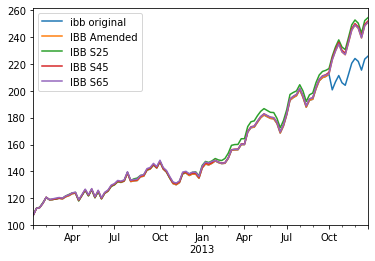

In [28]:
# plot results and 2-norm differences 
pd.Series(ibb['calibrate']['lp'].as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='ibb original', legend=True) 
pd.Series(lp_amended.as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='IBB Amended', legend=True)

for s in [25, 45, 65]:
    pd.Series(ibb_predict['calibrate'][s], index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='IBB S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['calibrate'][s])    


# Phase 3: Validating

In [29]:
for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    
    # load our trained models
    deep_learner = load_model('model/beat_s' + str(s) + '.h5')
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage/100) + 1
    
    ibb_predict['validate'][s] = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
#     total_2_norm_diff['validate'][s] = np.linalg.norm((ibb_predict['validate'][s] - ibb['validate']['lp']))

Again, we would like to see how similar these 3 portfolios perform as the original IBB Index does, but on test dates.

/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


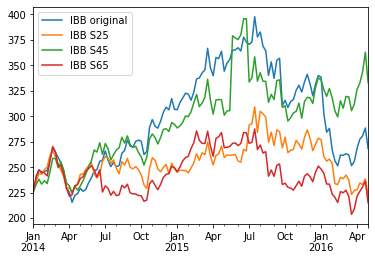

In [30]:
# plot original IBB last price
pd.Series(ibb['validate']['lp'].as_matrix(), index=pd.date_range(start='01/03/2014', periods=122, freq='W')).plot(label='IBB original', legend=True) 

# 2-norm difference is now meaningless to compare
for s in [25, 45, 65]:
    pd.Series(ibb_predict['validate'][s], index=pd.date_range(start='01/03/2014', periods = 122,freq='W')).plot(label='IBB S'+str(s), legend=True)